##### Import libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime as dt

print(f'Tensorflow version: {tf.__version__}')

2023-08-04 16:44:42.623031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.12.0


##### Definition of model training hyperparameters

In [10]:
EPOCHS = 5
BATCH_SIZE = 64

##### Modeling data fetching

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [12]:
max_value = train_x.max().astype(np.float32)

# Data normalization
train_x, test_x = train_x / max_value, test_x / max_value

# Data expand dimension(for adding a channel)
# (NONE, 28, 28) --> (NONE, 28, 28, 1)
train_x, test_x = tf.expand_dims(train_x, -1), tf.expand_dims(test_x, -1)

* Creating the final dataset for training and test

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(train_x.shape[0]).batch(BATCH_SIZE)
# Test data is generally not shuffled
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(BATCH_SIZE)

##### Model define

* kargs

In [18]:
kargs = {
    'model_name': 'MnistCnnClassifier',
    'input_size': 128,
    'conv_dim': 256,
    'full_dim': 512,
    'output_dim': 10,
}

* model

In [19]:
class MnistCnnClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MnistCnnClassifier, self).__init__(name=kargs['model_name'])
        
        self._input     = tf.keras.layers.Conv2D(kargs['input_size'], 3, activation='relu')
        self._hidden_1  = tf.keras.layers.Conv2D(kargs['conv_dim'], 3, activation='relu')
        self._hidden_2  = tf.keras.layers.Conv2D(kargs['conv_dim'], 3, activation='relu')
        self._flatten   = tf.keras.layers.Flatten()
        self._full_con  = tf.keras.layers.Dense(kargs['full_dim'], activation='relu')
        self._output    = tf.keras.layers.Dense(kargs['output_dim'], activation='softmax')
        
    def call(self, input):
        _model = self._input(input)
        _model = self._hidden_1(_model)
        _model = self._hidden_2(_model)
        _model = self._flatten(_model)
        _model = self._full_con(_model)
        _model = self._output(_model)
        return _model

##### Create model with 'compile' and 'fit'

In [20]:
model_original = MnistCnnClassifier(**kargs)
model_original.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseCategoricalCrossentropy(name='loss'),
    ]
)

In [21]:
_dt_training_start = dt.now()

model_original.fit(
    train_ds, 
    # train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_ds,
    # validation_data=(test_x, test_y),
)

print(f'Total training time: {dt.now() - _dt_training_start}')

Epoch 1/5


938/938 [==============================] - 22s 21ms/step - loss: 0.1248 - accuracy: 0.9619 - val_loss: 0.0427 - val_accuracy: 0.9862
Epoch 2/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0357 - accuracy: 0.9891 - val_loss: 0.0337 - val_accuracy: 0.9889
Epoch 3/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.0237 - val_accuracy: 0.9924
Epoch 4/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.0283 - val_accuracy: 0.9908
Epoch 5/5
938/938 [==============================] - 19s 20ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.0300 - val_accuracy: 0.9908
Total training time: 0:01:37.435746


* Evaluation

In [36]:
# _test_evaluation = model_original.evaluate(test_x, test_y)
# print(f'Final: {_test_evaluation}')

_test_loss, _test_accuracy, _ = model_original.evaluate(test_x, test_y)
print(f'Final: loss({_test_loss:.06f}), accuracy({_test_accuracy:.06f})')

  1/313 [..............................] - ETA: 8s - loss: 0.0509 - accuracy: 0.9688

313/313 [==============================] - 2s 7ms/step - loss: 0.0300 - accuracy: 0.9908
Final: loss(0.029997), accuracy(0.990800)


* Service

In [22]:
def service_original(idx):
    _sample_data = tf.reshape(test_x[idx], (1, 28, 28, 1))
    _predict = model_original.predict(_sample_data)
    _predict = tf.reshape(_predict, (10))       # (1,10) => (10) 즉, 2차원 배열을 1차원 배열로 변경
    _x_labels = list(range(0, _predict.numpy().size))   # 0~9
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.imshow(_sample_data[0, :, :, 0], aspect='auto')
    plt.title('Sample image to be predicted')
    
    plt.subplot(1, 2, 2)
    plt.bar(_x_labels, _predict)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Probability of being the corresponding number')
    
    plt.tight_layout()
    plt.show()
    
    _predict = tf.math.argmax(_predict)       # <tf.Tensor: shape=(), dtype=int64, numpy=7>
    _predict = _predict.numpy()
    print(f'label: {test_y[idx]}, predict: {_predict}')

1/1 [==============================] - 0s 185ms/step


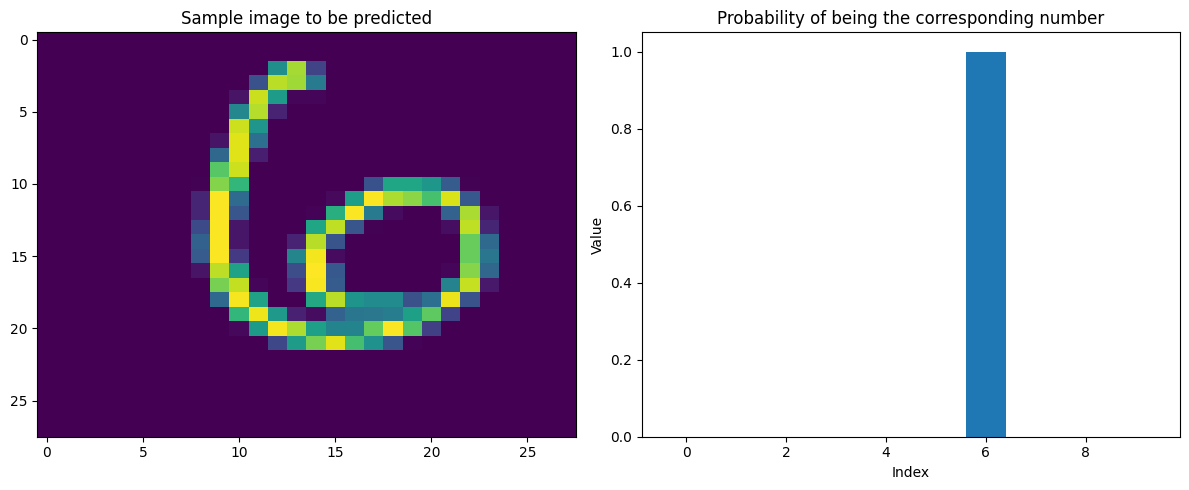

label: 6, predict: 6


In [23]:
service_original(100)

1/1 [==============================] - 0s 23ms/step


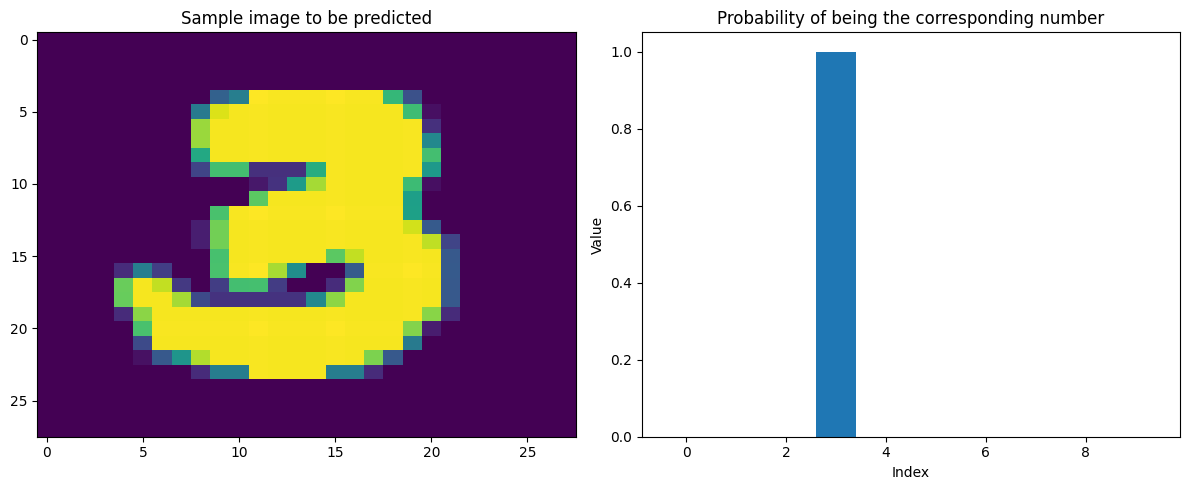

label: 3, predict: 3


In [24]:
service_original(200)

1/1 [==============================] - 0s 25ms/step


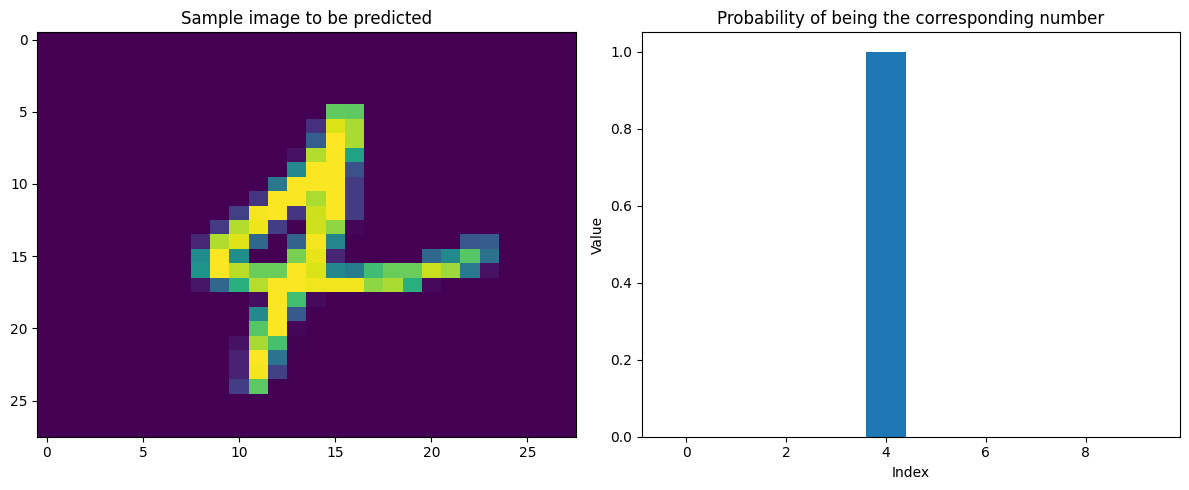

label: 4, predict: 4


In [25]:
service_original(300)

##### Create model with GradientTape

In [38]:
model_gradient_tape = MnistCnnClassifier(**kargs)

* Define loss, optimizer, accuracy

In [39]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

* Define train and test function

In [40]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        _predictions = model_gradient_tape(images, training=True)
        _loss = loss(labels, _predictions)
    _gradients = tape.gradient(_loss, model_gradient_tape.trainable_variables)
    optimizer.apply_gradients(zip(_gradients, model_gradient_tape.trainable_variables))
    train_loss(_loss)
    train_accuracy(labels, _predictions)

In [41]:
@tf.function
def test_step(images, labels):
    _predictions = model_gradient_tape(images, training=False)
    _loss = loss(labels, _predictions)
    test_loss(_loss)
    test_accuracy(labels, _predictions)

* Define training function

In [42]:
dt_msg = ''
def training_model_gradient_tape(is_display_time=True):
    for epoch in range(EPOCHS):
        if is_display_time:
            _dt_epoch_start = dt.now()
        
        train_loss.reset_state()
        train_accuracy.reset_state()
        test_loss.reset_state()
        test_accuracy.reset_state()
        
        for images, labels in train_ds:
            train_step(images, labels)
            
        for images, labels in test_ds:
            test_step(images, labels)
            
        if is_display_time:
            _dt_epoch_end = dt.now()
            dt_msg = f', Processing time: {_dt_epoch_end - _dt_epoch_start}'
            
        print(
            f'Epoch: {epoch+1}, '
            f'Train: loss({train_loss.result():.05f}), accuracy({train_accuracy.result():.05f}), '
            f'Test: loss({test_loss.result():.05f}), accuracy({test_accuracy.result():.05f})'
            f'{dt_msg}'
        )

* Training

In [52]:
_dt_training_start = dt.now()

training_model_gradient_tape()

print(f'Total processing time: {dt.now() - _dt_training_start}')

Epoch: 1, Train: loss(0.00326), accuracy(0.99890), Test: loss(0.04756), accuracy(0.98950), Processing time: 0:00:14.027217
Epoch: 2, Train: loss(0.00234), accuracy(0.99928), Test: loss(0.04613), accuracy(0.99030), Processing time: 0:00:14.065866
Epoch: 3, Train: loss(0.00169), accuracy(0.99952), Test: loss(0.03730), accuracy(0.99240), Processing time: 0:00:14.130419
Epoch: 4, Train: loss(0.00031), accuracy(0.99988), Test: loss(0.04446), accuracy(0.99220), Processing time: 0:00:14.204894
Epoch: 5, Train: loss(0.00305), accuracy(0.99900), Test: loss(0.04510), accuracy(0.99010), Processing time: 0:00:14.226218
Total processing time: 0:01:10.705309


* Service

In [20]:
def service_gradient_tape(idx):
    _sample_data = tf.reshape(test_x[idx], (1, 28, 28, 1))
    _predict = model_gradient_tape.predict(_sample_data)
    _predict = tf.reshape(_predict, (10))       # (1,10) => (10) 즉, 2차원 배열을 1차원 배열로 변경
    _x_labels = list(range(0, _predict.numpy().size))   # 0~9
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.imshow(_sample_data[0, :, :, 0], aspect='auto')
    plt.title('Sample image to be predicted')
    
    plt.subplot(1, 2, 2)
    plt.bar(_x_labels, _predict)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Probability of being the corresponding number')
    
    plt.tight_layout()
    plt.show()
    
    _predict = tf.math.argmax(_predict)       # <tf.Tensor: shape=(), dtype=int64, numpy=7>
    _predict = _predict.numpy()
    print(f'label: {test_y[idx]}, predict: {_predict}')

1/1 [==============================] - 0s 60ms/step


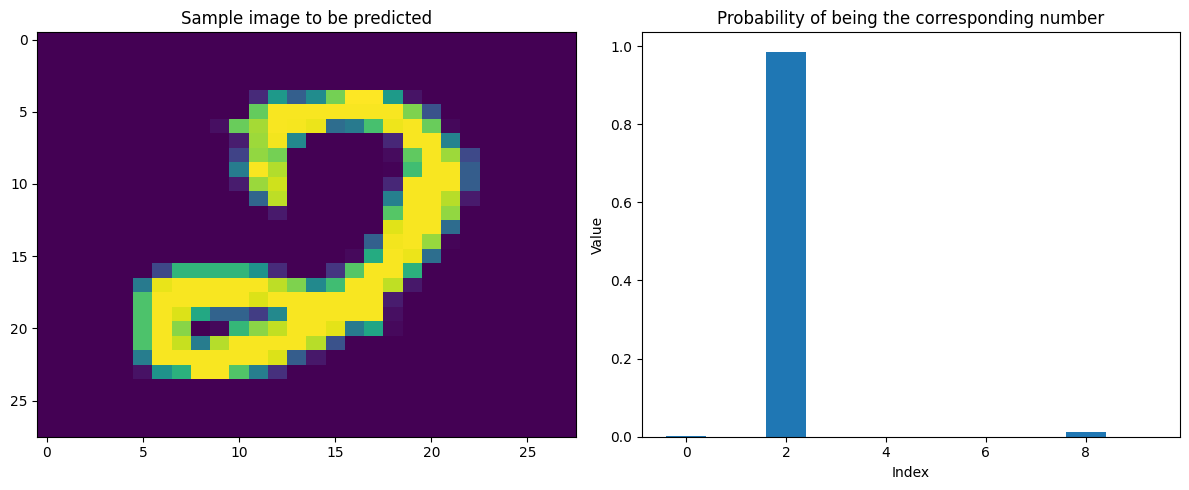

label: 2, predict: 2


In [21]:
service_gradient_tape(400)

1/1 [==============================] - 0s 24ms/step


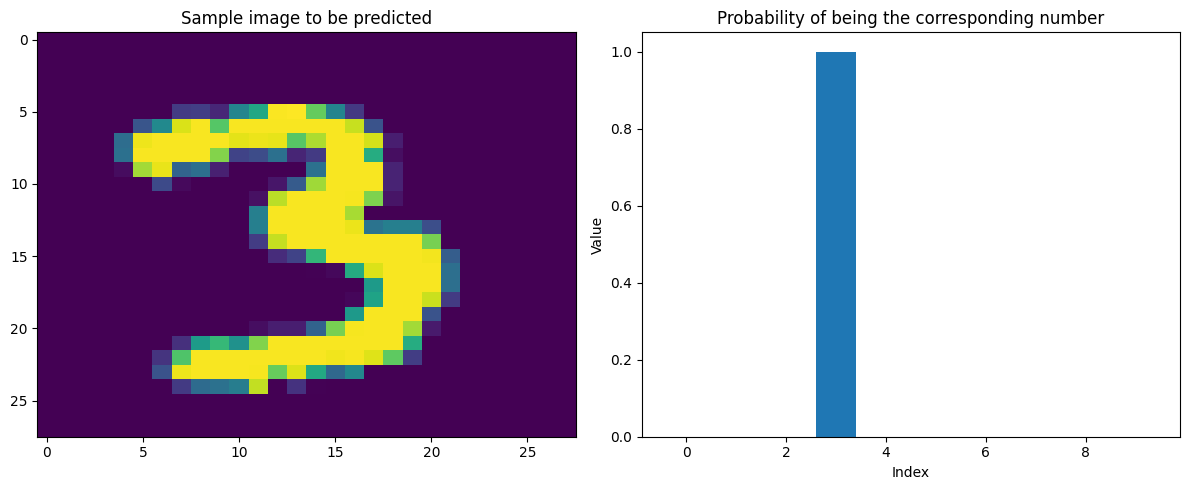

label: 3, predict: 3


In [22]:
service_gradient_tape(500)

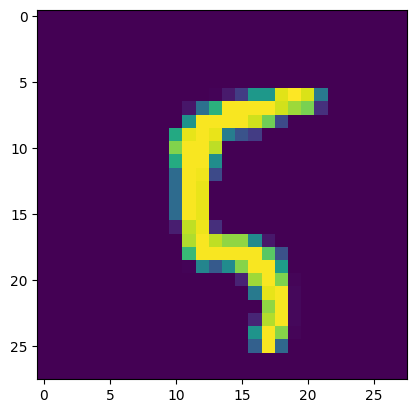

In [4]:
plt.imshow(train_x[100])
plt.show()